In [9]:
import os
import json
from collections import defaultdict, OrderedDict
from os import path
import numpy as np

In [2]:
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f.readlines():
            data.append(json.loads(line.strip()))
    
    return data

In [6]:
litbank_file = "/home/shtoshni/Research/litbank_coref/data/all.512.jsonl"
litbank_data = load_jsonl(litbank_file)
print(len(litbank_data))

100


In [7]:
def get_cluster_spans(coref_chains):
    cluster_spans = []
    for chain in coref_chains:
        min_start = 1e9
        max_end = 0
        for (span_start, span_end) in chain:
            min_start = min(span_start, min_start)
            max_end = max(span_end, max_end)
            
        cluster_spans.append((min_start, max_end))
    return cluster_spans

In [19]:
def get_max_active_chains(cluster_spans):
    last_mention_idx = max([span_end for _, span_end in cluster_spans])
    num_clusters = len(cluster_spans)
    
    # Boolean variable that marks whether a cluster is active at certain time step or not
    active_chains = np.zeros((num_clusters, last_mention_idx), dtype=np.int32)
    for idx, (span_start, span_end) in enumerate(cluster_spans):
        active_chains[idx, span_start:span_end] = 1
    
    active_chain_sum = np.sum(active_chains, axis=0)
    assert(last_mention_idx == len(active_chain_sum)) # Just to make sure summing over right dimension
    
    return np.max(active_chain_sum), np.argmax(active_chain_sum)

In [17]:
def get_doc_tokens(sentences):
    doc_tokens = []
    for sent in sentences:
        doc_tokens.extend(sent)
    return doc_tokens

In [39]:
max_active_chains = 0
corr_doc_idx = None
within_doc_idx = None

chain_spread = []
for doc_idx, instance in enumerate(litbank_data):
    cluster_spans = get_cluster_spans(instance["clusters"])
    for (span_start, span_end) in cluster_spans:
        chain_spread.append(span_end - span_start)
    doc_tokens = get_doc_tokens(instance["sentences"])
    instance_max_active_chains, instance_within_doc_idx = get_max_active_chains(cluster_spans)
    print(instance["doc_key"], instance_max_active_chains)
    if max_active_chains < instance_max_active_chains:
        max_active_chains = instance_max_active_chains
        corr_doc_idx = doc_idx
        within_doc_idx = instance_within_doc_idx

1023_bleak_house_brat 9
105_persuasion_brat 15
1064_the_masque_of_the_red_death_brat 8
110_tess_of_the_durbervilles_a_pure_woman_brat 9
11231_bartleby_the_scrivener_a_story_of_wallstreet_brat 6
113_the_secret_garden_brat 11
1155_the_secret_adversary_brat 5
11_alices_adventures_in_wonderland_brat 4
1206_the_flying_u_ranch_brat 10
120_treasure_island_brat 13
1245_night_and_day_brat 15
1260_jane_eyre_an_autobiography_brat 13
12677_personality_plus_some_experiences_of_emma_mcchesney_and_her_son_jock_brat 5
1327_elizabeth_and_her_german_garden_brat 9
1342_pride_and_prejudice_brat 12
1400_great_expectations_brat 11
145_middlemarch_brat 10
15265_the_quest_of_the_silver_fleece_a_novel_brat 7
155_the_moonstone_brat 13
158_emma_brat 14
160_the_awakening_and_selected_short_stories_brat 14
16357_mary_a_fiction_brat 8
1661_the_adventures_of_sherlock_holmes_brat 9
1695_the_man_who_was_thursday_a_nightmare_brat 6
171_charlotte_temple_brat 10
174_the_picture_of_dorian_gray_brat 9
18581_adrift_in_new_y

In [25]:
print("Max active chains in Litbank: {} present in {}".format(max_active_chains, litbank_data[corr_doc_idx]["doc_key"]))

Max active chains in Litbank: 18 present in 2891_howards_end_brat


In [26]:
doc_tokens = get_doc_tokens(litbank_data[corr_doc_idx]["sentences"])
print(doc_tokens[within_doc_idx - 5: within_doc_idx + 5])

['made', 'by', 'the', 'Kings', 'of', 'Me', '##rcia', '-', '-', 'tennis']


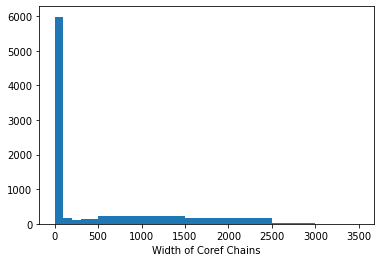

In [38]:
import matplotlib.pyplot as plt

a = plt.hist(chain_spread, bins=[0, 100, 200, 300, 500, 1000, 1500, 2000, 2500, 3000, 3500])
plt.xlabel("Width of Coref Chains")
plt.savefig("/home/shtoshni/Research/litbank_coref/figs/cluster_spread.jpg", dpi=300)